In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Download and unzip the data

In [0]:
!wget https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0 -O male_female.tgz
!tar -xzvf male_female.tgz

#### Examine the data

In [0]:
import os

In [0]:
from IPython.display import display,Image

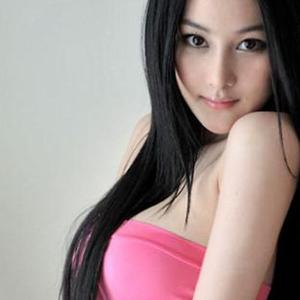

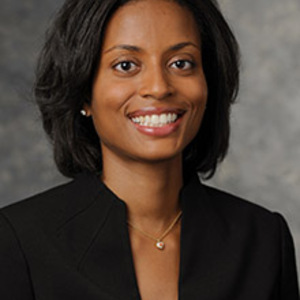

In [0]:
os.chdir('/data/train/0_female')

imagelist = os.listdir()[1123:1125]

for name in imagelist:
  display(Image(filename=name))
 

In [0]:
from itertools import islice

#### Build a deep learning model

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization
from keras.callbacks import EarlyStopping

In [0]:
K.clear_session()

model = Sequential()

# Convolutional layer
model.add(Conv2D(filters = 64,kernel_size=(3,3),activation = 'relu',input_shape = (64,64,3)))

model.add(Conv2D(filters = 32,kernel_size =(3,3),activation = 'relu'))

# Pooling layer
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32,kernel_size =(3,3),activation = 'relu'))

model.add(MaxPool2D(pool_size = (2,2)))

# Flatten before passing to a Dense layer
model.add(Flatten())
model.add(Dense(units = 128,activation = 'relu'))

# Batch normalization
model.add(BatchNormalization())

model.add(Dense(units = 10,activation = 'relu'))

model.add(BatchNormalization())

model.add(Dense(1,activation = 'sigmoid'))

model.compile(metrics = ['accuracy'],loss='binary_crossentropy',optimizer='sgd')

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                307530    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 308,477
Trainable params: 308,457
Non-trainable params: 20
_______________________________________________

In [0]:
# Generate image data with real-time data augmentation 
from keras.preprocessing.image import ImageDataGenerator


In [0]:
# pass transforming operations as arguments
generator_train = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True
                               )

generator_test = ImageDataGenerator(rescale = 1./255)

In [0]:
data_path_train = '/data/train'
data_path_test = '/data/test'

In [0]:
# generate batches of augmented data
train = generator_train.flow_from_directory(data_path_train,
                                            target_size=(64,64),
                                            batch_size=16,
                                            class_mode='binary')

Found 11655 images belonging to 2 classes.


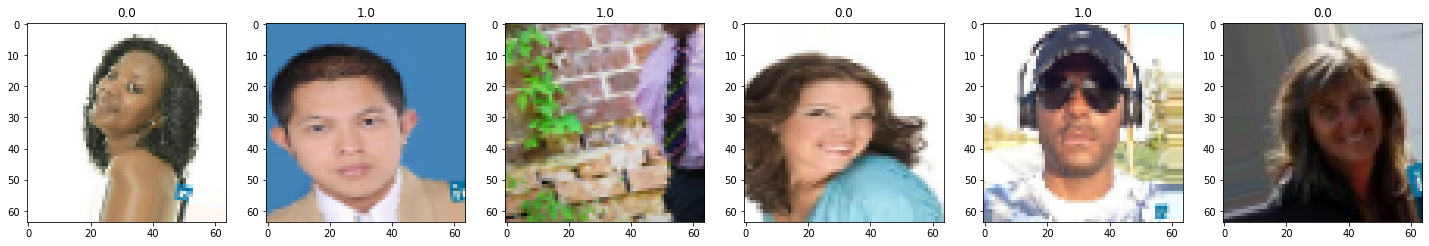

In [0]:
# check out some of these generated low resolution images along with their labels
plt.figure(figsize = (25,20))

for i in range(1,7):
  img,label = train.next()
  plt.subplot(1,6,i)
  plt.title(label[0])
  plt.imshow(img[0])


In [0]:
test = generator_test.flow_from_directory(data_path_test,target_size=(64,64),batch_size =16,
                                            class_mode='binary')

Found 2916 images belonging to 2 classes.


In [0]:
# fit the train data
model.fit_generator(train,epochs=10,validation_data=test)

#### Evaluate and analyze the model

In [0]:
X_test = []
y_test = []

for ts in islice(test,50):
  X_test.append(ts[0])
  y_test.append(ts[1])
 

In [0]:
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [0]:
y_test[799]

0.0

In [0]:
y_pred = model.predict_classes(X_test).ravel()

In [0]:
# there are 800 images because we had 50 batches of size 16 each
y_pred.shape

(800,)

In [0]:
# use the AUROC metric for evaluation

from sklearn.metrics import roc_auc_score

In [0]:
# the performance is considerably above the benchmark of 50%. It can be further improved by simply running more epochs.
roc_auc_score(y_test,y_pred)

0.7740601503759398

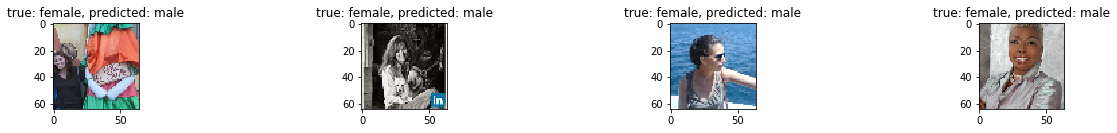

In [0]:
# check some of the images that were misclassified. Display the true and the predicted labels for each. 
start=70
end = 110
c = 1
plt.figure(figsize=(15,10))
for i in range(start,end):
  if y_pred[i] != y_test[i]:
    plt.subplot(1,end-start-10,c)
    plt.imshow(X_test[i])
    plt.title('true: {}, predicted: {}'.format('female' if y_test[i]==0 else 'male','female' if y_pred[i]==0 else 'male'))
    c += 3
    

In [0]:
# detect the images that have been misclassified
np.argwhere(y_test != y_pred).ravel()

array([ 11,  18,  26,  27,  37,  40,  42,  45,  54,  61,  64,  71,  75,
        86,  89,  94, 105, 109, 112, 113, 120, 124, 127, 128, 130, 133,
       136, 139, 140, 146, 147, 149, 150, 161, 163, 165, 167, 192, 193,
       197, 199, 201, 219, 220, 226, 231, 241, 244, 247, 251, 252, 255,
       259, 260, 262, 269, 275, 277, 279, 281, 282, 284, 288, 294, 296,
       298, 299, 302, 304, 308, 320, 322, 325, 330, 338, 344, 348, 364,
       370, 379, 384, 385, 386, 390, 394, 397, 405, 407, 410, 413, 414,
       418, 422, 428, 429, 431, 433, 434, 437, 439, 441, 447, 448, 453,
       456, 462, 469, 474, 479, 485, 489, 492, 497, 506, 515, 521, 523,
       525, 526, 529, 533, 542, 544, 552, 556, 561, 562, 565, 567, 568,
       569, 577, 579, 582, 585, 586, 601, 606, 609, 613, 614, 616, 617,
       618, 623, 624, 625, 631, 632, 637, 642, 643, 645, 649, 651, 666,
       668, 676, 687, 691, 692, 693, 695, 714, 716, 717, 718, 726, 734,
       744, 761, 762, 766, 772, 774, 782, 783, 788, 793, 799])